In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
plt.style.use('seaborn-whitegrid')
import datetime

dtypes={
    'key': 'object',
    'fare_amount': 'float64',
    'pickup_datetime' : 'str',
    'pickup_longitude': 'float64',
    'pickup_latitude': 'float64',
    'dropoff_longitude': 'float64',
    'dropoff_latitude': 'float64',
    'passenger_count': 'int64',
}
parse_dates = ['pickup_datetime']

In [2]:
print('reading train dataset')
%time train = pd.read_csv('../input/train.csv', dtype=dtypes)
print('Sample train')
%time train = train.sample(n=10000000,random_state=1997)
print('drop NA')
%time train.dropna(axis=0,subset=['dropoff_longitude','dropoff_latitude'],inplace=True)
print('reading test dataset')
%time test = pd.read_csv('../input/test.csv', dtype=dtypes)
datasets = [train,test]

for dataset in datasets:
    print(dataset.shape)

reading train dataset
CPU times: user 2min 5s, sys: 34.1 s, total: 2min 39s
Wall time: 2min 39s
Sample train
CPU times: user 15.4 s, sys: 856 ms, total: 16.3 s
Wall time: 16.2 s
drop NA
CPU times: user 4.62 s, sys: 328 ms, total: 4.94 s
Wall time: 4.94 s
reading test dataset
CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 28.5 ms
(9999931, 8)
(9914, 7)


In [ ]:
train.head()

In [3]:
key_test = test['key'].copy()

In [4]:
for dataset in datasets:
    dataset.drop('key',axis=1,inplace=True)
train.head()
datasets = [train,test]

In [5]:
train.columns = ['preco','dt_inicio','long_inicio','lat_inicio','long_fim','lat_fim','qtd_passageiros']
test.columns = ['dt_inicio','long_inicio','lat_inicio','long_fim','lat_fim','qtd_passageiros']
train.head()

,preco,dt_inicio,long_inicio,lat_inicio,long_fim,lat_fim,qtd_passageiros
21085244,6.5,2012-05-19 13:25:00 UTC,-73.953272,40.785340,-73.966357,40.764612,1
7363895,8.9,2009-09-14 11:09:24 UTC,-74.007408,40.726717,-73.991335,40.755170,1
8472376,6.5,2011-09-26 19:25:37 UTC,-73.952631,40.786483,-73.950349,40.772287,1
15164275,9.3,2012-02-14 06:40:00 UTC,-73.985240,40.723685,-73.979750,40.752125,1
41155882,6.9,2010-09-24 07:27:00 UTC,-73.967240,40.766025,-73.951723,40.769472,1


**Distance Calculator**

In [7]:
from math import radians, cos, sin, asin, sqrt

def haversine(row):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lon1, lat1, lon2, lat2 = row
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [8]:
def distancia_aeroporto_jfk(long,lat):
    centro_aeroporto = [40.649299, -73.782923]
    distancia = haversine(centro_aeroporto + [long,lat])
    return distancia

In [10]:
for dataset in datasets:
    dataset['distancia'] = [haversine(x) for x in dataset[['long_inicio','lat_inicio','long_fim','lat_fim']].values]
    dataset['distancia_jfk_inicio'] = [distancia_aeroporto_jfk(*x) for x in dataset[['long_inicio','lat_inicio']].values]    
datasets = [train,test]

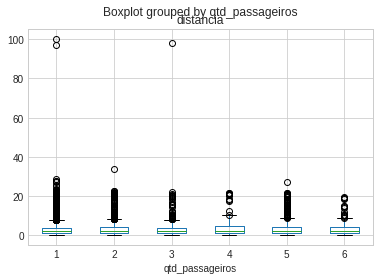

,long_inicio,lat_inicio,long_fim,lat_fim,qtd_passageiros,distancia,distancia_jfk_inicio
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273,3.435371,15082.398474
std,0.042774,0.033541,0.039072,0.035435,1.278747,3.972374,3.345645
min,-74.252193,40.573143,-74.263242,40.568973,1.000000,0.000000,15063.939155
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000,1.298277,15081.260281
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000,2.217412,15082.788281
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000,4.045302,15083.889443
max,-72.986532,41.709555,-72.990963,41.696683,6.000000,99.996040,15151.269117


In [11]:
test.boxplot(column=['distancia'], by='qtd_passageiros')
plt.show()
test.describe()

In [23]:
train = train[train['preco'].between(0,700)]
train = train[train['distancia'] < 100]
train = train[train['qtd_passageiros'].between(0,6)]
train = train[train['long_inicio'].between(-74,-72)]
train = train[train['lat_inicio'].between(39,42)]
train = train[train['long_fim'].between(-75,-71)]
train = train[train['lat_fim'].between(39,42)]
corridas_com_precos_exagerados = train.query('distancia < 5 and preco > 150').index
train.drop(corridas_com_precos_exagerados, inplace=True)
corridas_com_precos_exagerados = train.query('preco < 5 and distancia > 40').index
train.drop(corridas_com_precos_exagerados, inplace=True)
datasets = [train,test]

In [13]:
for dataset in datasets:
    dataset['dt_inicio'] = dataset['dt_inicio'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S UTC'))
    dataset['ano_inicio'] = dataset['dt_inicio'].apply(lambda x: datetime.datetime.strftime(x, '%Y')).astype('float64')
    dataset['mes_inicio'] = dataset['dt_inicio'].apply(lambda x: datetime.datetime.strftime(x, '%m')).astype('float64')
    dataset['dia_inicio'] = dataset['dt_inicio'].apply(lambda x: datetime.datetime.strftime(x, '%d')).astype('float64')
    dataset['hora_inicio'] = dataset['dt_inicio'].apply(lambda x: datetime.datetime.strftime(x, '%H')).astype('float64')
    dataset['dia_da_semana'] = dataset['dt_inicio'].apply(lambda x: x.weekday()).astype('float64')
    dataset.drop('dt_inicio', axis=1,inplace=True)
datasets = [train,test]

In [14]:
train.head()

,preco,long_inicio,lat_inicio,long_fim,lat_fim,qtd_passageiros,distancia,distancia_jfk_inicio,ano_inicio,mes_inicio,dia_inicio,hora_inicio,dia_da_semana
21085244,6.5,-73.953272,40.785340,-73.966357,40.764612,1,2.554674,15085.295994,2012.0,5.0,19.0,13.0,5.0
8472376,6.5,-73.952631,40.786483,-73.950349,40.772287,1,1.590175,15085.394794,2011.0,9.0,26.0,19.0,0.0
15164275,9.3,-73.985240,40.723685,-73.979750,40.752125,1,3.196032,15079.886124,2012.0,2.0,14.0,6.0,1.0
41155882,6.9,-73.967240,40.766025,-73.951723,40.769472,1,1.361814,15083.722277,2010.0,9.0,24.0,7.0,4.0
26822757,16.5,-73.972282,40.796533,-73.990228,40.744438,1,5.986591,15087.037048,2010.0,4.0,12.0,9.0,0.0


In [15]:
train.describe().round(2)

,preco,long_inicio,lat_inicio,long_fim,lat_fim,qtd_passageiros,distancia,distancia_jfk_inicio,ano_inicio,mes_inicio,dia_inicio,hora_inicio,dia_da_semana
count,8470940.00,8470940.00,8470940.00,8470940.00,8470940.00,8470940.00,8470940.00,8470940.00,8470940.00,8470940.00,8470940.00,8470940.00,8470940.00
mean,11.28,-73.97,40.75,-73.97,40.75,1.68,3.30,15082.62,2011.74,6.27,15.71,13.56,3.03
std,9.73,0.04,0.03,0.04,0.03,1.31,3.81,3.34,1.87,3.44,8.69,6.43,1.95
min,0.00,-74.00,39.08,-74.88,39.09,0.00,0.00,14866.30,2009.00,1.00,1.00,0.00,0.00
25%,6.00,-73.99,40.74,-73.99,40.74,1.00,1.23,15081.67,2010.00,3.00,8.00,9.00,1.00
50%,8.10,-73.98,40.76,-73.98,40.76,1.00,2.10,15083.01,2012.00,6.00,16.00,14.00,3.00
75%,12.50,-73.97,40.77,-73.96,40.77,2.00,3.80,15084.10,2013.00,9.00,23.00,19.00,5.00
max,450.00,-72.08,41.96,-72.06,41.99,6.00,99.99,15193.71,2015.00,12.00,31.00,23.00,6.00


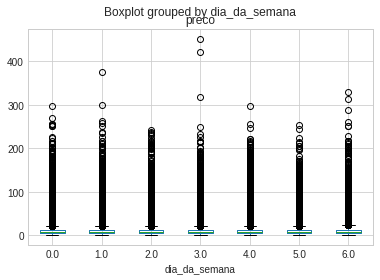

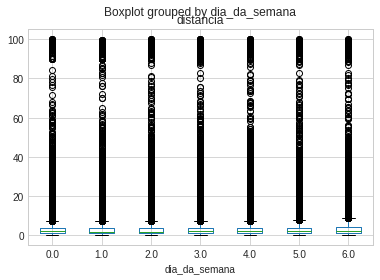

In [16]:
train.boxplot(column=['preco'],by='dia_da_semana')
plt.show()
train.boxplot(column=['distancia'],by='dia_da_semana')
plt.show()

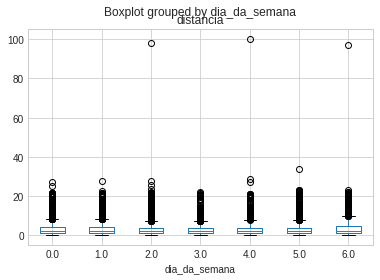

,long_inicio,lat_inicio,long_fim,lat_fim,qtd_passageiros,distancia,distancia_jfk_inicio,ano_inicio,mes_inicio,dia_inicio,hora_inicio,dia_da_semana
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273,3.435371,15082.398474,2011.815816,6.857979,16.194170,13.467420,2.852834
std,0.042774,0.033541,0.039072,0.035435,1.278747,3.972374,3.345645,1.803347,3.353272,8.838482,6.868584,1.994451
min,-74.252193,40.573143,-74.263242,40.568973,1.000000,0.000000,15063.939155,2009.000000,1.000000,1.000000,0.000000,0.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000,1.298277,15081.260281,2010.000000,4.000000,9.000000,8.000000,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000,2.217412,15082.788281,2012.000000,7.000000,16.000000,15.000000,3.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000,4.045302,15083.889443,2014.000000,10.000000,25.000000,19.000000,5.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000,99.996040,15151.269117,2015.000000,12.000000,31.000000,23.000000,6.000000


In [17]:
test.boxplot(column=['distancia'], by='dia_da_semana')
plt.show()
test.describe()

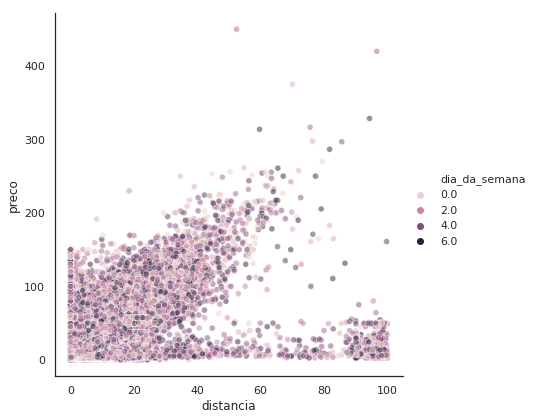

In [18]:
sns.set(style="white")
sns.relplot(x="distancia", y="preco", hue="dia_da_semana",
            sizes=(40, 400), alpha=.5,
            height=6, data=train)
plt.show()

In [21]:
for dataset in datasets:
    #Madrugada - 23 às 5 => valor: 1
    #Manhã - 6 às 11 => valor: 2
    #Tarde - 12 às 17 => valor: 3
    #Noite - 18 às 22 => valor: 4
    dataset['periodo_dia_inicio'] = np.where(dataset['hora_inicio'].between(6,11,inclusive=True),2,
                                            np.where(dataset['hora_inicio'].between(12,17,inclusive=True),3,
                                                    np.where(dataset['hora_inicio'].between(18,12,inclusive=True),4,1)))
datasets = [train,test]

In [22]:
train.head()

,preco,long_inicio,lat_inicio,long_fim,lat_fim,qtd_passageiros,distancia,distancia_jfk_inicio,ano_inicio,mes_inicio,dia_inicio,hora_inicio,dia_da_semana,periodo_dia_inicio
21085244,6.5,-73.953272,40.785340,-73.966357,40.764612,1,2.554674,15085.295994,2012.0,5.0,19.0,13.0,5.0,3
8472376,6.5,-73.952631,40.786483,-73.950349,40.772287,1,1.590175,15085.394794,2011.0,9.0,26.0,19.0,0.0,1
15164275,9.3,-73.985240,40.723685,-73.979750,40.752125,1,3.196032,15079.886124,2012.0,2.0,14.0,6.0,1.0,2
41155882,6.9,-73.967240,40.766025,-73.951723,40.769472,1,1.361814,15083.722277,2010.0,9.0,24.0,7.0,4.0,2
26822757,16.5,-73.972282,40.796533,-73.990228,40.744438,1,5.986591,15087.037048,2010.0,4.0,12.0,9.0,0.0,2


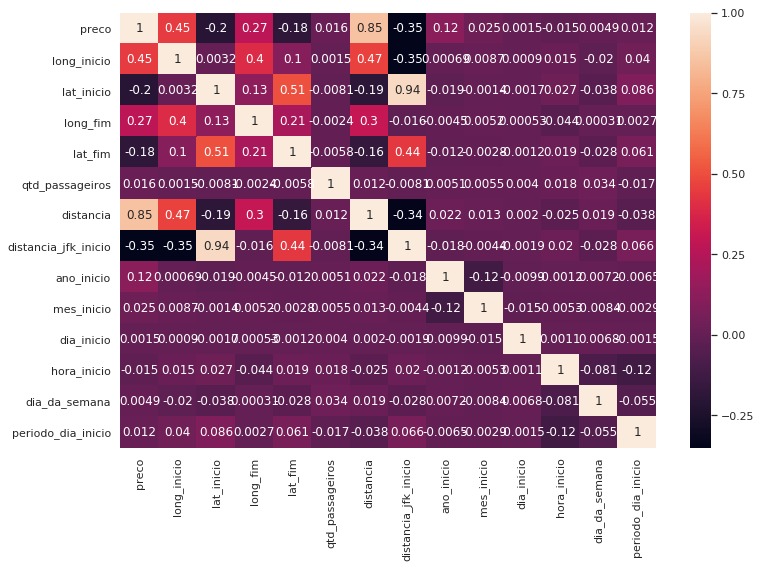

In [24]:
plt.figure(figsize=(12,8))
sns.heatmap(train.corr(), annot=True)
plt.show()

In [25]:
# define some handy analysis support function
from sklearn.metrics import mean_squared_error, explained_variance_score

def plot_prediction_analysis(y, y_pred, figsize=(10,4), title=''):
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    axs[0].scatter(y, y_pred)
    mn = min(np.min(y), np.min(y_pred))
    mx = max(np.max(y), np.max(y_pred))
    axs[0].plot([mn, mx], [mn, mx], c='red')
    axs[0].set_xlabel('$y$')
    axs[0].set_ylabel('$\hat{y}$')
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    evs = explained_variance_score(y, y_pred)
    axs[0].set_title('rmse = {:.2f}, evs = {:.2f}'.format(rmse, evs))
    
    axs[1].hist(y-y_pred, bins=50)
    avg = np.mean(y-y_pred)
    std = np.std(y-y_pred)
    axs[1].set_xlabel('$y - \hat{y}$')
    axs[1].set_title('Histrogram prediction error, $\mu$ = {:.2f}, $\sigma$ = {:.2f}'.format(avg, std))
    
    if title!='':
        fig.suptitle(title)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


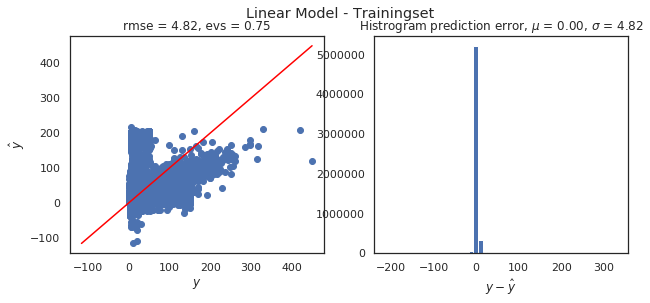

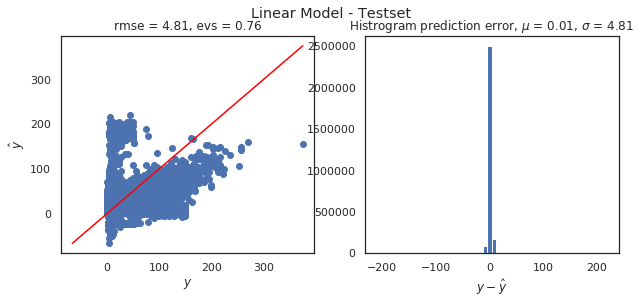

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

xtrain,xtest, ytrain,ytest = train_test_split(train.drop('preco',axis=1), train['preco'], test_size=0.33, random_state=1997)

model_lin = Pipeline((
        ("standard_scaler", StandardScaler()),
        ("lin_reg", LinearRegression()),
    ))
model_lin.fit(xtrain, ytrain)

y_train_pred = model_lin.predict(xtrain)
plot_prediction_analysis(ytrain, y_train_pred, title='Linear Model - Trainingset')

y_test_pred = model_lin.predict(xtest)
plot_prediction_analysis(ytest, y_test_pred, title='Linear Model - Testset')

In [27]:
y_sub_pred = model_lin.predict(test)

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [28]:
df_sub = pd.DataFrame()
df_sub['key'] = key_test
df_sub['fare_amount'] = y_sub_pred
df_sub.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.209427
1,2015-01-27 13:08:24.0000003,11.164918
2,2011-10-08 11:53:44.0000002,5.435769
3,2012-12-01 21:12:12.0000002,8.205169
4,2012-12-01 21:12:12.0000003,15.511947


In [29]:
df_sub.to_csv('submission.csv', index=False)